# Decision Trees & Random Forests

In [ ]:
###Checking which version of python is being used

from platform import python_version

print(python_version())

In [1]:
###Importing the necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format ='retina'
%matplotlib inline

In [ ]:
###Importing & checking the data

data = pd.read_csv("framingham.csv")
print(data.head())
print(data.shape)
print(data.dtypes)

In [ ]:
### Representing the data

fig = plt.figure(figsize = (15,20));
ax = fig.gca();
data.hist(ax = ax);

In [ ]:
###Checking correlation between data

data_corr = data.corr();
sns.heatmap(data_corr);

In [ ]:
data = data.drop(['education','glucose'], axis=1);
print(data.head())
print(data.shape)

In [ ]:
###Dropping missing data

print(data.isna().sum());
data = data.dropna();
print(data.isna().sum());
data.columns;


In [ ]:
###Spliting features and target variable
target = data.iloc[:,-1]
features = data.iloc[:,:-1]

print(target.head())
print(target.shape)
print(features.head())
print(features.shape)

In [ ]:
###Determining the top features using selectkbest, the higher the score the more likely they are linked

best = SelectKBest(score_func=chi2, k=10)
fit = best.fit(features, target)
data_scores = pd.DataFrame(fit.scores_)
data_columns = pd.DataFrame(features.columns)

feature_scores = pd.concat([data_columns,data_scores],axis=1) #Putting both into a single dataframe for clarity
feature_scores.columns = ['Feature','Score'] #Renaming columns

print(feature_scores.nlargest(10,'Score')) #Printing the top 10 features descending

In [ ]:
###Plotting a histogram based on the top features

feature_scores = feature_scores.sort_values(by='Score', ascending=False);

sns.barplot(x = 'Feature', y = 'Score', data = feature_scores)

plt.box(False)
plt.title('Feature importance', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.show();

In [ ]:
###Making a list of top features

feature_list = feature_scores['Feature'].tolist()[0:10]

print(feature_list)

In [ ]:
###Deleting data with less correlation with CHD from original dataframe

truncated_data = pd.concat([data[feature_list],data['TenYearCHD']],axis=1)

print(truncated_data.head())

In [ ]:
###Seeing correlation between truncated data

truncated_corr = truncated_data.corr()
sns.heatmap(truncated_corr);

In [ ]:
###Outlier detection

truncated_data.describe()
sns.pairplot(truncated_data);

In [ ]:
###Boxplots

column_name = list(truncated_data.columns);


for i in range(len(column_name)):
    sns.boxplot(truncated_data['{}'.format(column_name[i])]);
    plt.show();


In [ ]:
###Cleaning up the dataframe

def cleaning(dataframe, feature, upper):
    
    dataframe_original = dataframe
    dataframe = dataframe.drop(dataframe[dataframe['{}'.format(feature)] > upper].index);
    print('Shape: {} ---> {}'.format(dataframe_original.shape, dataframe.shape))
    return dataframe;

truncated_data = cleaning(truncated_data, 'totChol', 599);
truncated_data = cleaning(truncated_data, 'BMI', 50);
truncated_data = cleaning(truncated_data, 'cigsPerDay', 50);
truncated_data = cleaning(truncated_data, 'sysBP', 250);
print('Shape: {}' .format(truncated_data.shape));

In [ ]:
###Feature scaling

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = pd.DataFrame(scaler.fit_transform(truncated_data), columns=truncated_data.columns)

print(scaled_data.head())

In [ ]:
###Test
y = scaled_data.iloc[:,-1]
x = scaled_data.iloc[:,:-1]

print(y.head())
print(x.head())

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

print(len(x_train), len(x_test))

In [ ]:
###Resampling dataset
target_count = scaled_data.TenYearCHD.value_counts()

print(target_count[0])
print(target_count[1])
print(round(target_count[0] / target_count[1], 2), ': 1')

sns.countplot(scaled_data.TenYearCHD)
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease\n')
plt.show();

In [ ]:
shuffled_data = scaled_data.sample(frac=1,random_state=1)

CHD_data = shuffled_data.loc[shuffled_data['TenYearCHD'] == 1]
non_CHD_data = shuffled_data.loc[shuffled_data['TenYearCHD'] == 0].sample(n=target_count[1], random_state = 1)

print(CHD_data.shape)
print(non_CHD_data.shape)



In [ ]:
normalised_data = pd.concat([CHD_data, non_CHD_data])
normalised_data.TenYearCHD.value_counts()

normalised_target_count = normalised_data.TenYearCHD.value_counts()

sns.countplot(normalised_data.TenYearCHD)
print(round(normalised_target_count[0] / normalised_target_count[1], 2), ': 1')
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease\n')
plt.show();

In [ ]:
y_train = normalised_data.iloc[:,-1]
x_train = normalised_data.iloc[:,:-1]

In [ ]:
def scores(model, y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score (y_test, pred)
    
    print("The accuracy score for {} is: {}%.".format(model, round(accuracy,3)*100))
    print("The f1 score for {} is: {}%.".format(model, round(f1,3)*100))
    print("The precision score for {} is: {}%.".format(model, round(precision,3)*100))
    print("The recall score for {} is: {}%.".format(model, round(recall,3)*100))
    
    return(accuracy, f1, precision, recall)
    

In [ ]:
def confusion(dataframe, name):
    sns.heatmap(pd.DataFrame(dataframe), annot=True , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.title('Confusion matrix {}\n'.format(name), y=1.1)

In [ ]:
def model(classifier, name):
    classifier.fit(x_train, y_train);
    classifier_pred = classifier.predict(x_test);
    confusion(confusion_matrix(y_test, classifier_pred), name);
    scores(name, y_test, classifier_pred);

In [ ]:
dtc = DecisionTreeClassifier();
model(dtc, 'Decision Trees')

In [ ]:
rfc = RandomForestClassifier(n_estimators= 100,bootstrap = True, max_features = 'sqrt');
model(rfc, 'Random Forest')

## Looking at the number of trees

In [2]:
from preprocessing_ml import *

Importing the preprocessing module for the Exeter NatSci Machine Learning Group.....
Successfully imported the preprocessing module


In [3]:
X_train, X_test, y_train, y_test = split_data(scale_data(drop_missing(chose_features(pd.read_csv("framingham.csv")))))

In [4]:
def scores(name, y_test, pred, display):
    accuracy = accuracy_score(y_test, pred);
    f1 = f1_score(y_test, pred);
    precision = precision_score(y_test, pred);
    recall = recall_score(y_test, pred);
    
    if display == 'y':
        print("The accuracy score for {} is: {}%.".format(name, round(accuracy, 3) * 100))
        print("The f1 score for {} is: {}%.".format(name, round(f1, 3) * 100))
        print("The precision score for {} is: {}%.".format(name, round(precision, 3) * 100))
        print("The recall score for {} is: {}%.".format(name, round(recall, 3) * 100))
        return(accuracy, f1, precision, recall);
    elif display == 'n':
        return(accuracy, f1, precision, recall);
    else:
        print("Error: please choose 'y' or 'n'.")

In [5]:
def model(classifier, name, X_train, X_test, y_train, y_test, display):
    classifier.fit(X_train, y_train);
    classifier_pred = classifier.predict(X_test);
    score = scores(name, y_test, classifier_pred, display);
    
    accuracy = score[0];
    f1 = score[1];
    precision = score[2];
    recall = score[3];
    
    return(accuracy, f1, precision, recall);

In [6]:
model(DecisionTreeClassifier(), 'Decision Tree', X_train, X_test, y_train, y_test, 'y');

The accuracy score for Decision Tree is: 73.0%.
The f1 score for Decision Tree is: 22.0%.
The precision score for Decision Tree is: 21.4%.
The recall score for Decision Tree is: 22.8%.


In [7]:
model(RandomForestClassifier(n_estimators=10, bootstrap=True), 'Random Forest', X_train, X_test, y_train, y_test, 'y');

The accuracy score for Random Forest is: 83.1%.
The f1 score for Random Forest is: 16.2%.
The precision score for Random Forest is: 48.0%.
The recall score for Random Forest is: 9.8%.


In [8]:
y = np.linspace(1,1000,100);
accuracy_list = [];
for i in range(len(y)):
    accuracy_list.append(model(RandomForestClassifier(n_estimators=i+1, bootstrap=True), 'Random Forest', X_train, X_test, y_train, y_test, 'n')[0]);

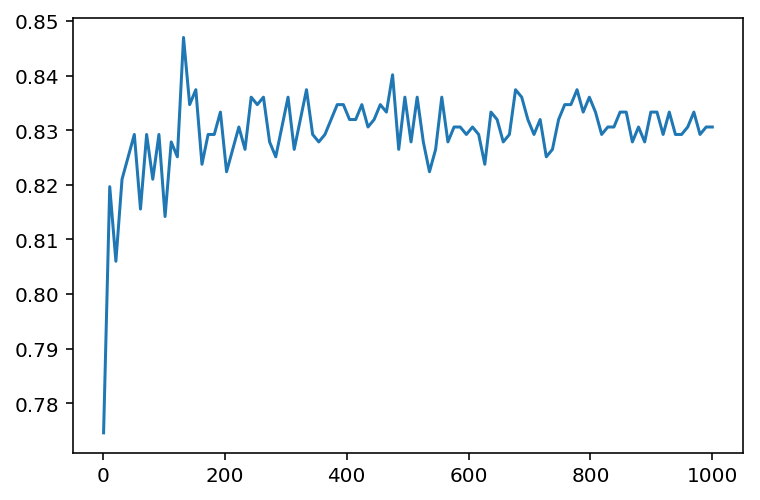

In [9]:
plt.plot(y, accuracy_list);
plt.show();

## Applying the Model

In [10]:
input_data = pd.DataFrame(columns = X_train.columns)
input_data.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,BMI,prevalentStroke,education,heartRate,currentSmoker


In [11]:
data = [{'sysBP':120, 'glucose':100, 'age':35, 'totChol':350, 'cigsPerDay':10, 'diaBP':120, 'prevalentHyp':1, 'diabetes':0, 'BPMeds':1, 'male':1, 'BMI':45, 'prevalentStroke':0, 'education': 3, 'heartRate': 76, 'currentSmoker':1}]

In [12]:
my_data = input_data.append(data,ignore_index=True)
my_data.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,BMI,prevalentStroke,education,heartRate,currentSmoker
0,120,100,35,350,10,120,1,0,1,1,45,0,3,76,1


In [20]:
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = pd.DataFrame(scaler.fit_transform(my_data), columns=my_data.columns)

scaled_data.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,male,BMI,prevalentStroke,education,heartRate,currentSmoker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
